# Text Generator

In [81]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

## Load data from TXT

Download Data Set: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

In [82]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
    print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Generating features and labels from n_grams sequences, tokenization, padding and one hot encoding.

In [83]:
# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

print(f'total words: {total_words}')

total words: 3211


In [84]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:

	# Tokenize the current line
	token_list = tokenizer.texts_to_sequences([line])[0] # texts_to_sequences expects a list of strings as input

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):

		# Generate the subphrase
		n_gram_sequence = token_list[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create inputs and label by splitting the last token in the subphrases
features, labels = input_sequences[:,:-1], input_sequences[:,-1]

# Convert the label into one-hot arrays
one_hot_labels = to_categorical(labels, num_classes=total_words)

In [93]:
print(f"padded corpus shape: {input_sequences.shape}")
print(f"features shape: {features.shape}")
print(f"labels shape: {labels.shape}")
print(f"one_hot_labels shape: {one_hot_labels.shape}")

padded corpus shape: (15462, 11)
features shape: (15462, 10)
labels shape: (15462,)
one_hot_labels shape: (15462, 3211)


In [97]:
sentence = corpus[0][:-1].split()
print(f'sample sentence: {sentence}')

token_list = []
for word in sentence:
	token_list.append(tokenizer.word_index[word])

print(f'token list: {token_list}')
print("\nFirst 5 features look like this:")
print(features[:5,:])
print("\nFirst 5 labels look like this:")
print(labels[:5])

sample sentence: ['from', 'fairest', 'creatures', 'we', 'desire', 'increase']
token list: [34, 417, 877, 166, 213, 517]

First 5 features look like this:
[[  0   0   0   0   0   0   0   0   0  34]
 [  0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0  34 417 877]
 [  0   0   0   0   0   0  34 417 877 166]
 [  0   0   0   0   0  34 417 877 166 213]]

First 5 labels look like this:
[417 877 166 213 517]


## Model

In [118]:
def create_model(total_words, max_sequence_len):
	"""
	Creates a text generator model
	Args:
		total_words (int): size of the vocabulary for the Embedding layer input
		max_sequence_len (int): length of the input sequences
	Returns:
		model (tf.keras Model): the text generator model
	"""
	# Hyperparameter
	embedding_dim = 100
	lstm_units = 150
	learning_rate = 0.01

	# Architecture
	model = Sequential([
		Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
		Bidirectional(LSTM(lstm_units)),
		Dense(total_words, activation='softmax')
	])

	# Compile the model
	model.compile(loss='categorical_crossentropy',
				  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
				  metrics=['accuracy'])
	return model

In [119]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Print the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 10, 100)           321100    
                                                                 
 bidirectional_4 (Bidirectio  (None, 300)              301200    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 3211)              966511    
                                                                 
Total params: 1,588,811
Trainable params: 1,588,811
Non-trainable params: 0
_________________________________________________________________


In [120]:
# Train the model
history = model.fit(features, one_hot_labels, epochs=25)

Epoch 1/25
484/484 [==============================] - 15s 25ms/step - loss: 6.7824 - accuracy: 0.0332
Epoch 2/25
484/484 [==============================] - 12s 26ms/step - loss: 6.0632 - accuracy: 0.0589
Epoch 3/25
484/484 [==============================] - 13s 26ms/step - loss: 5.3700 - accuracy: 0.0866
Epoch 4/25
484/484 [==============================] - 13s 26ms/step - loss: 4.5775 - accuracy: 0.1369
Epoch 5/25
484/484 [==============================] - 13s 26ms/step - loss: 3.7627 - accuracy: 0.2277
Epoch 6/25
484/484 [==============================] - 12s 25ms/step - loss: 3.0732 - accuracy: 0.3254
Epoch 7/25
484/484 [==============================] - 12s 25ms/step - loss: 2.5204 - accuracy: 0.4269
Epoch 8/25
484/484 [==============================] - 12s 25ms/step - loss: 2.1134 - accuracy: 0.5088
Epoch 9/25
484/484 [==============================] - 12s 25ms/step - loss: 1.8256 - accuracy: 0.5631
Epoch 10/25
484/484 [==============================] - 12s 24ms/step - loss: 1.619

## Accuracy and Loss

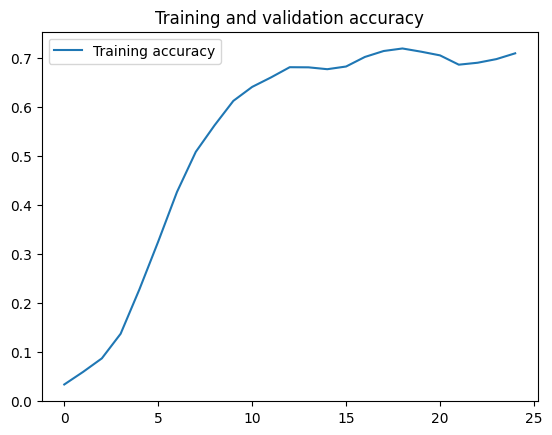

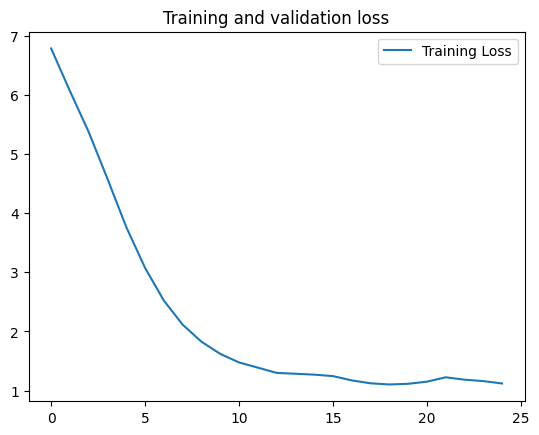

In [123]:
def plot_acc_val(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(len(acc)) # Get number of epochs

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc, label='Training accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss, label='Training Loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_acc_val(history)

## Generating Text

In [128]:
# Define seed text
seed_text = "Help me Obi Wan Kenobi, you're my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(token_list)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:

		# Look up the word associated with the index.
		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result
print(seed_text)

1/1 [==============================] - 0s 22ms/step
Help me Obi Wan Kenobi, you're my only hope me my love of me thee you ' ' ' you night doth thee give thee ' he doth lose ' is thee ' ' ' thee ' thee again ' more ' more ' more ' more ' greater in me see me me me go wide ' more ' forbear so chary me true ' ' thee ' thee ' ' now rare now foes commend ' thee ' thee me ' is more ' more ' ' more ' tongue ' more ' more ' both grow it in forth ' go ' ' have erred '


### Randomize the top 3 predictions

In [130]:
# Define seed text
seed_text = "Help me Obi Wan Kenobi, you're my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
    probabilities = model.predict(token_list)

    # Pick a random number from [1,2,3]
    choice = np.random.choice([1,2,3])

    # Sort the probabilities in ascending order
    # and get the random choice from the end of the array
    predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
    if predicted != 0:

	    # Look up the word associated with the index.
	    output_word = tokenizer.index_word[predicted]

	    # Combine with the seed text
	    seed_text += " " + output_word

# Print the result
print(seed_text)

1/1 [==============================] - 0s 25ms/step
Help me Obi Wan Kenobi, you're my only hope thy life and land foul thence thou bent ' away ' thee ' loss on me ' thence me ' on thee living in posterity live thee in thine ' thee ' more 'will' me me thee more ' ' me gone here ' me so foes ' no more rare night ' more thence it 'will' me this ' night ' is more rich friend ' me bright ' both me 'will' ' me thence me me ' both to thee but thee ' me prove thee gone more foes thee doth me thence you bold ' ' thence
